# Libraries

In [73]:
import os
import sys
import random
import tempfile
import textwrap

import numpy as np
import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from torchvision.models import resnet18

from PIL import Image

from datasets import load_dataset
from transformers import AutoTokenizer, GPT2Config, GPT2LMHeadModel

import cadquery as cq
from cadquery import exporters

import trimesh

from pathlib import Path
from typing import Optional, Tuple, Union, Dict, List

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from IPython.display import clear_output, display

def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Eval Metrics

### IOU Metric

In [74]:
def _load_solid_from_code(
    code: str, script_id: str = "unknown"
) -> Union[cq.Solid, cq.Compound]:
    cleaned_code = textwrap.dedent(code).strip()

    ns = {"cq": cq, "cadquery": cq, "np": np, "numpy": np, "__builtins__": __builtins__}
    try:
        exec(cleaned_code, ns)
    except Exception as e:
        raise ValueError(f"Error executing script {script_id}: {e}")

    cadquery_objects = []
    for var_name, var_value in ns.items():
        if isinstance(var_value, (cq.Workplane, cq.Solid, cq.Compound)):
            cadquery_objects.append((var_name, var_value))

    if not cadquery_objects:
        raise ValueError(
            f"No CadQuery objects (Workplane, Solid, or Compound) found in script {script_id}"
        )

    if len(cadquery_objects) > 1:
        preferred_names = ["solid", "result", "shape", "part", "object", "obj", "res"]
        for preferred in preferred_names:
            for var_name, var_value in cadquery_objects:
                if var_name == preferred:
                    cadquery_objects = [(var_name, var_value)]
                    break
            if len(cadquery_objects) == 1:
                break

        if len(cadquery_objects) > 1:
            var_names = [name for name, _ in cadquery_objects]
            print(
                f"Warning: Multiple CadQuery objects found in {script_id}: {var_names}. Using '{cadquery_objects[0][0]}'"
            )

    var_name, solid_obj = cadquery_objects[0]

    if isinstance(solid_obj, cq.Workplane):
        solid_obj = solid_obj.val()

    if hasattr(solid_obj, "Solids") and callable(getattr(solid_obj, "Solids")):
        solids = solid_obj.Solids()
        if len(solids) == 1:
            solid_obj = solids[0]
        elif len(solids) > 1:
            pass  
        else:
            raise ValueError(f"No solids found in compound in script {script_id}")

    if not isinstance(solid_obj, (cq.Solid, cq.Compound)):
        raise ValueError(
            f"CadQuery object '{var_name}' is not a Solid or Compound object in script {script_id}, got {type(solid_obj)}"
        )

    return solid_obj


def _load_solid(script_path: Path) -> cq.Solid:
    """Import a CadQuery script in isolation and return the 'solid' object."""
    ns = runpy.run_path(script_path)  
    if "solid" not in ns or not isinstance(ns["solid"], cq.Solid):
        raise ValueError(f"'solid' not found in {script_path}")
    return ns["solid"]


def _root_gyration(solid: Union[cq.Solid, cq.Compound]) -> float:
    vol = solid.Volume()
    inertia = np.array(cq.Shape.matrixOfInertia(solid)).reshape(3, 3)
    return np.sqrt(np.trace(inertia) / (2.0 * vol))


def _normalized_mesh(
    solid: Union[cq.Solid, cq.Compound], pitch: float = 0.01
) -> trimesh.Trimesh:
    """Translate to centroid, isotropically scale by r_g, and return a mesh."""
    r_g = _root_gyration(solid)
    center_vector = solid.Center()
    centroid = np.array([center_vector.x, center_vector.y, center_vector.z])
    # Export to temporary STL then load with trimesh
    with tempfile.TemporaryDirectory() as tmp:
        stl_path = Path(tmp) / "part.stl"
        exporters.export(solid, str(stl_path))
        mesh = trimesh.load(str(stl_path), force="mesh")
    mesh.apply_translation(-centroid)
    mesh.apply_scale(1.0 / r_g)
    return mesh


def _principal_axes(mesh: trimesh.Trimesh) -> np.ndarray:
    """Return 3×3 orthonormal matrix whose columns are principal axes."""
    inertia = mesh.moment_inertia
    _, vecs = np.linalg.eigh(inertia)
    return vecs  # columns are eigenvectors


def _apply_rotation(mesh: trimesh.Trimesh, R: np.ndarray) -> trimesh.Trimesh:
    T = np.eye(4)
    T[:3, :3] = R
    mesh_rot = mesh.copy()
    mesh_rot.apply_transform(T)
    return mesh_rot


def _voxel_bool_unified(
    mesh1: trimesh.Trimesh, mesh2: trimesh.Trimesh, pitch: float = 0.05
) -> tuple[np.ndarray, np.ndarray]:
    """Create voxel grids for both meshes using unified bounds."""
    # Voxelize each mesh individually first
    voxel1 = mesh1.voxelized(pitch)
    voxel2 = mesh2.voxelized(pitch)

    # Get the bounds of each voxel grid
    bounds1 = voxel1.bounds
    bounds2 = voxel2.bounds

    # Compute unified bounds
    min_bounds = np.minimum(bounds1[0], bounds2[0])
    max_bounds = np.maximum(bounds1[1], bounds2[1])

    # Calculate grid dimensions
    grid_size = np.ceil((max_bounds - min_bounds) / pitch).astype(int)

    # Create empty unified voxel grids
    vox1 = np.zeros(grid_size, dtype=bool)
    vox2 = np.zeros(grid_size, dtype=bool)

    # Calculate offsets for placing each voxel grid in the unified space
    offset1 = np.round((bounds1[0] - min_bounds) / pitch).astype(int)
    offset2 = np.round((bounds2[0] - min_bounds) / pitch).astype(int)

    # Get shapes of individual voxel matrices
    shape1 = voxel1.matrix.shape
    shape2 = voxel2.matrix.shape

    # Calculate end positions
    end1 = offset1 + shape1
    end2 = offset2 + shape2

    # Place voxels in unified grids with bounds checking
    if np.all(offset1 >= 0) and np.all(end1 <= grid_size):
        vox1[offset1[0] : end1[0], offset1[1] : end1[1], offset1[2] : end1[2]] = (
            voxel1.matrix
        )

    if np.all(offset2 >= 0) and np.all(end2 <= grid_size):
        vox2[offset2[0] : end2[0], offset2[1] : end2[1], offset2[2] : end2[2]] = (
            voxel2.matrix
        )

    return vox1, vox2


def _voxel_bool(mesh: trimesh.Trimesh, pitch: float = 0.05) -> np.ndarray:
    vox = mesh.voxelized(pitch)
    return vox.matrix  # boolean 3-D numpy array


def iou_best(
    mesh_gt: trimesh.Trimesh, mesh_pred: trimesh.Trimesh, pitch: float = 0.05
) -> float:
    """IOU after best principal-axis alignment (4 valid sign flips)."""
    axes_gt = _principal_axes(mesh_gt)
    axes_pr = _principal_axes(mesh_pred)

    best = 0.0
    for signs in [(1, 1, 1), (1, 1, -1), (1, -1, 1), (-1, 1, 1)]:
        D = np.diag(signs)
        axes_pr_flipped = axes_pr @ D  # change axis directions
        R = axes_gt @ axes_pr_flipped.T  # rotation to align
        m_aligned = _apply_rotation(mesh_pred, R)

        # Use unified voxelization
        vox_gt, vox_pr = _voxel_bool_unified(mesh_gt, m_aligned, pitch)

        inter = np.logical_and(vox_gt, vox_pr).sum()
        union = np.logical_or(vox_gt, vox_pr).sum()

        if union > 0:
            iou = inter / union
            best = max(best, iou)

    return best


def evaluate_codes(gt_codes: dict, pred_codes: dict, pitch: float = 0.05):
    """Evaluate predictions against ground-truth using Python code directly.

    Args:
        gt_codes: Dict with IDs as keys and ground-truth Python code as values
        pred_codes: Dict with IDs as keys and prediction Python code as values
        pitch: Voxel pitch for IoU calculation
    """
    ids = sorted(gt_codes.keys())
    if not ids:
        sys.exit("no ground-truth scripts provided")

    vsr_success = 0
    ious = []

    for _id in ids:
        if _id not in pred_codes:
            print(f"missing prediction for {_id}, skipping")
            continue

        try:
            solid_gt = _load_solid_from_code(gt_codes[_id], f"gt_{_id}")
            solid_pr = _load_solid_from_code(pred_codes[_id], f"pred_{_id}")
            vsr_success += 1
        except Exception as exc:
            print(f"{_id}: syntax/runtime error -> {exc}")
            continue

        mesh_gt = _normalized_mesh(solid_gt)
        mesh_pr = _normalized_mesh(solid_pr)
        ious.append(iou_best(mesh_gt, mesh_pr, pitch))

    n_total = len(ids)
    vsr = vsr_success / n_total if n_total else 0.0
    iou_b = np.mean(ious) if ious else 0.0

    print(f"Valid Syntax Rate: {vsr:.3f}")
    print(f"Mean IOU_best   : {iou_b:.3f}")

    return {"vsr": vsr, "iou_best": iou_b}


def evaluate(gt_dir: Path, pred_dir: Path, pitch: float = 0.05):
    """Original file-based evaluation function."""
    ids = sorted(p.stem for p in gt_dir.glob("*.py"))
    if not ids:
        sys.exit("no ground-truth scripts found")

    vsr_success = 0
    ious = []

    for _id in ids:
        gt_path = gt_dir / f"{_id}.py"
        pr_path = pred_dir / f"{_id}.py"
        if not pr_path.exists():
            print(f"missing prediction for {_id}, skipping")
            continue

        try:
            solid_gt = _load_solid(gt_path)
            solid_pr = _load_solid(pr_path)
            vsr_success += 1
        except Exception as exc:
            print(f"{_id}: syntax/runtime error -> {exc}")
            continue

        mesh_gt = _normalized_mesh(solid_gt)
        mesh_pr = _normalized_mesh(solid_pr)
        ious.append(iou_best(mesh_gt, mesh_pr, pitch))

    n_total = len(ids)
    vsr = vsr_success / n_total if n_total else 0.0
    iou_b = np.mean(ious) if ious else 0.0

    print(f"Valid Syntax Rate: {vsr:.3f}")
    print(f"Mean IOU_best   : {iou_b:.3f}")


def get_iou_best(code1: str, code2: str):
    solid1 = _load_solid_from_code(code1)
    solid2 = _load_solid_from_code(code2)
    mesh1 = _normalized_mesh(solid1)
    mesh2 = _normalized_mesh(solid2)
    iou = iou_best(mesh1, mesh2)
    return iou

### Syntax Metric

In [75]:
def _load_solid_from_code(
    code: str, script_id: str = "unknown"
) -> Union[cq.Solid, cq.Compound]:
    cleaned_code = textwrap.dedent(code).strip()

    ns = {"cq": cq, "cadquery": cq, "np": np, "numpy": np, "__builtins__": __builtins__}
    try:
        exec(cleaned_code, ns)
    except Exception as e:
        raise ValueError(f"Error executing script {script_id}: {e}")

    # Find any CadQuery objects in the namespace
    cadquery_objects = []
    for var_name, var_value in ns.items():
        if isinstance(var_value, (cq.Workplane, cq.Solid, cq.Compound)):
            cadquery_objects.append((var_name, var_value))

    if not cadquery_objects:
        raise ValueError(
            f"No CadQuery objects (Workplane, Solid, or Compound) found in script {script_id}"
        )

    if len(cadquery_objects) > 1:
        # If multiple objects, prefer common names
        preferred_names = ["solid", "result", "shape", "part", "object", "obj", "res"]
        for preferred in preferred_names:
            for var_name, var_value in cadquery_objects:
                if var_name == preferred:
                    cadquery_objects = [(var_name, var_value)]
                    break
            if len(cadquery_objects) == 1:
                break

        # If still multiple, just take the first one but warn
        if len(cadquery_objects) > 1:
            var_names = [name for name, _ in cadquery_objects]
            print(
                f"Warning: Multiple CadQuery objects found in {script_id}: {var_names}. Using '{cadquery_objects[0][0]}'"
            )

    var_name, solid_obj = cadquery_objects[0]

    if isinstance(solid_obj, cq.Workplane):
        solid_obj = solid_obj.val()

    if hasattr(solid_obj, "Solids") and callable(getattr(solid_obj, "Solids")):
        solids = solid_obj.Solids()
        if len(solids) == 1:
            solid_obj = solids[0]
        elif len(solids) > 1:
            pass  # Keep the compound as is
        else:
            raise ValueError(f"No solids found in compound in script {script_id}")

    if not isinstance(solid_obj, (cq.Solid, cq.Compound)):
        raise ValueError(
            f"CadQuery object '{var_name}' is not a Solid or Compound object in script {script_id}, got {type(solid_obj)}"
        )

    return solid_obj


def evaluate_syntax_rate(
    codes: Dict[str, str], verbose: bool = True
) -> Dict[str, Union[float, int, List[str]]]:
    if not codes:
        if verbose:
            print("No code provided")
        return {"vsr": 0.0, "successful": 0, "total": 0, "failed_ids": []}

    ids = sorted(codes.keys())
    successful_count = 0
    failed_ids = []

    for script_id in ids:
        code = codes[script_id]
        try:
            solid = _load_solid_from_code(code, script_id)
            successful_count += 1
            if verbose:
                print(f"✓ {script_id}: Successfully executed")
        except Exception as exc:
            failed_ids.append(script_id)
            if verbose:
                print(f"✗ {script_id}: {exc}")

    total_count = len(ids)
    vsr = successful_count / total_count if total_count > 0 else 0.0

    if verbose:
        print(f"\n--- SUMMARY ---")
        print(f"Successful: {successful_count}/{total_count}")
        print(f"Valid Syntax Rate: {vsr:.3f}")
        if failed_ids:
            print(f"Failed IDs: {failed_ids}")

    return {
        "vsr": vsr,
        "successful": successful_count,
        "total": total_count,
        "failed_ids": failed_ids,
    }


def evaluate_syntax_rate_simple(codes: Dict[str, str]) -> float:
    result = evaluate_syntax_rate(codes, verbose=False)
    return result["vsr"]

# Dataset

In [76]:
# seed for repro
set_seed(42)

# dataset
class CadQueryDataset(Dataset):
    def __init__(self, split="train", im_size=224, limit=None, verbose=False):
        self.ds = load_dataset(
            "CADCODER/GenCAD-Code",
            split=split,
            cache_dir="/Volumes/BIG-DATA/HUGGINGFACE_CACHE",
        )

        if verbose: 
            print(f"Available keys in dataset item: {list(self.ds[0].keys())}")
        
        # I use it just to overfit a tiny dataset
        if limit is not None:
            self.ds = self.ds.select(range(min(limit, len(self.ds))))
            print(f"Restricted to {len(self.ds)} samples for split '{split}'.")

        self.tokenizer = AutoTokenizer.from_pretrained("gpt2")
        if self.tokenizer.pad_token is None:
            self.tokenizer.pad_token = self.tokenizer.eos_token
        if self.tokenizer.bos_token is None:
            self.tokenizer.add_special_tokens({'bos_token': '<BOS>'})
        if self.tokenizer.eos_token is None:
            self.tokenizer.add_special_tokens({'eos_token': '<EOS>'})
            
        self.transform = transforms.Compose([
            transforms.Resize((im_size, im_size)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ])
    
    def __len__(self):
        return len(self.ds)
    
    def __getitem__(self, idx):
        item = self.ds[idx]
        
        image = item["image"]
        
        if not isinstance(image, Image.Image):
            if hasattr(image, 'numpy'):  
                image_array = image.numpy() if hasattr(image, 'numpy') else image
                
                if image_array.dtype != np.uint8:
                    image_array = (image_array * 255).astype(np.uint8)
                image = Image.fromarray(image_array)
            else:
                image = Image.fromarray(image)
        
        # Convert to RGB
        if image.mode != 'RGB':
            image = image.convert('RGB')
        
        # Apply transforms
        image = self.transform(image)
        
        # Process code 
        code_tokens = self.tokenizer(
            item["cadquery"], 
            return_tensors="pt", 
            padding="max_length", 
            max_length=128, 
            truncation=True,
            add_special_tokens=True 
        )
        
        input_ids = code_tokens.input_ids.squeeze(0)
        attention_mask = code_tokens.attention_mask.squeeze(0)
        
        return image, input_ids, attention_mask

##### sanity check #####
b_size = 4
im_size = 224

# Load the train dataset
full_train_dataset = CadQueryDataset(split="train", im_size=im_size, limit=100)

# Split 
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size

# fixed seed
generator = torch.Generator().manual_seed(42)
train_dataset, val_dataset = random_split(
    full_train_dataset, 
    [train_size, val_size],
    generator=generator
)

# Load test dataset
test_dataset = CadQueryDataset(split="test", im_size=im_size)

print(f"Dataset sizes - Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")

# Create data loaders with worker_init_fn for reproducibility
def worker_init_fn(worker_id):
    np.random.seed(42 + worker_id)
    random.seed(42 + worker_id)

train_loader = DataLoader(
    train_dataset, 
    batch_size=b_size, 
    num_workers=0, 
    shuffle=True,
    worker_init_fn=worker_init_fn,
    generator=torch.Generator().manual_seed(42)
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=b_size, 
    num_workers=0, 
    shuffle=False,  
    worker_init_fn=worker_init_fn
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=b_size, 
    num_workers=0, 
    shuffle=False,  
    worker_init_fn=worker_init_fn
)

Restricted to 100 samples for split 'train'.
Dataset sizes - Train: 80, Val: 20, Test: 7355


Testing train loader...
Image batch shape: torch.Size([4, 3, 224, 224])
Input IDs batch shape: torch.Size([4, 128])
Attention mask batch shape: torch.Size([4, 128])
Sample input IDs: tensor([11748, 20603, 22766,   355,   269,    80,   198,     2,  2980,   803])


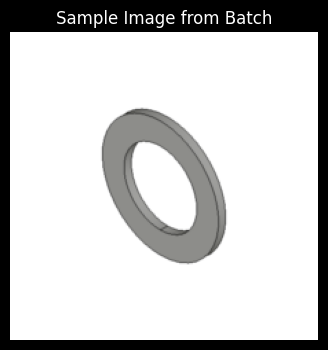

In [77]:
# Test the data loader
print("Testing train loader...")
for images, input_ids, attention_mask in train_loader:
    print("Image batch shape:", images.shape)
    print("Input IDs batch shape:", input_ids.shape)
    print("Attention mask batch shape:", attention_mask.shape)
    print("Sample input IDs:", input_ids[0][:10]) 
    break

# Take the first image in the batch
img = images[0].cpu()

# Undo normalization
mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
img = img * std + mean
img = img.clamp(0, 1)
img_np = img.permute(1, 2, 0).numpy()

plt.figure(figsize=(4, 4))
plt.imshow(img_np)
plt.axis('off')
plt.title('Sample Image from Batch')
plt.show()

# Model

In [78]:
class ImageToCodeModel(nn.Module):   
    def __init__(
        self, 
        vocab_size: int,
        code_pad_token_id: int,
        bos_token_id: int,
        eos_token_id: int,
        n_embd: int = 512,
        dec_h_dim: int = 256,
        n_dec_layers: int = 2,
        n_heads: int = 8,
        max_pos_embs: int = 256,
        dropout: float = 0.0
    ):
        super().__init__()
        
        # Store configuration
        self.vocab_size = vocab_size
        self.dec_h_dim = dec_h_dim
        self.code_pad_token_id = code_pad_token_id
        
        # Encoder: ResNet18 without final classification layer
        self._build_encoder()
        
        # Feature projection layer
        self.feature_projection = nn.Sequential(
            nn.Linear(n_embd, dec_h_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.LayerNorm(dec_h_dim)
        )
        
        # Code Decoder: GPT-2 based language model
        self._build_decoder(
            vocab_size, bos_token_id, eos_token_id, code_pad_token_id,
            dec_h_dim, n_dec_layers, n_heads, 
            max_pos_embs, dropout
        )
    
    def _build_encoder(self) -> None:
        resnet = resnet18(pretrained=True)
        modules = list(resnet.children())[:-2]  
        self.encoder = nn.Sequential(*modules)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        # Freeze encoder weights for fine-tuning 
        # for param in self.encoder.parameters():
        #     param.requires_grad = False
    
    def _build_decoder(
        self, 
        vocab_size: int, 
        bos_token_id: int, 
        eos_token_id: int, 
        pad_token_id: int,
        h_dim: int, 
        n_layers: int, 
        n_heads: int, 
        max_positions: int,
        dropout: float
    ) -> None:
        config = GPT2Config(
            vocab_size=vocab_size,
            n_positions=max_positions,
            n_embd=h_dim,
            n_layer=n_layers,
            n_head=n_heads,
            n_inner=h_dim * 4,  # Standard
            resid_pdrop=dropout,
            embd_pdrop=dropout,
            attn_pdrop=dropout,
            bos_token_id=bos_token_id,
            eos_token_id=eos_token_id,
            pad_token_id=pad_token_id,
        )
        config.loss_type = "cross_entropy" 
        self.decoder = GPT2LMHeadModel(config)
    
    def encode_image(self, images: torch.Tensor) -> torch.Tensor:
        feats = self.encoder(images)                        # [B, 512, H, W]
        feats = self.adaptive_pool(feats)                   # [B, 512, 1, 1]
        feats = feats.squeeze(-1).squeeze(-1)               # [B, 512]
        proj_feats = self.feature_projection(feats)         # [B, dec_h_dim]
        
        return proj_feats
    
    def forward(
        self, 
        images: torch.Tensor, 
        input_ids: torch.Tensor, 
        attention_mask: Optional[torch.Tensor] = None,
        labels: Optional[torch.Tensor] = None
    ) -> dict:
        b_size, _ = input_ids.shape
        
        # Encode images
        img_feats = self.encode_image(images)                               # [B, dec_h_dim]
        img_embs = img_feats.unsqueeze(1)                                   # [B, 1, dec_h_dim]
        
        # Get token embeddings for code sequence
        code_embs = self.decoder.transformer.wte(input_ids)                 # [B, seq_len, dec_h_dim]
        
        # Think of Image here as a Condition
        dec_embs = torch.cat([img_embs, code_embs], dim=1)                  # [B, 1+seq_len, dec_h_dim]
        
        # Extend attention mask for image token
        if attention_mask is not None:
            img_attention = torch.ones(b_size, 1, device=attention_mask.device, dtype=attention_mask.dtype)
            extended_attention_mask = torch.cat([img_attention, attention_mask], dim=1)
        else:
            extended_attention_mask = None
        
        # Prepare labels if provided (shift for causal language modeling)
        if labels is not None:
            extended_labels = torch.cat([
                torch.full((b_size, 1), -100, device=labels.device, dtype=labels.dtype),  
                labels 
            ], dim=1)
        else:
            extended_labels = None
        
        # decoder Forward
        outputs = self.decoder(
            inputs_embeds=dec_embs,
            attention_mask=extended_attention_mask,
            labels=extended_labels,
            return_dict=True
        )

        logits = outputs.logits
        loss = outputs.loss

        return logits, loss


    def generate_code(
        self, 
        images: torch.Tensor, 
        max_length: int = 128,
        temperature: float = 1.0,
        do_sample: bool = True,
        top_k: int = 50,
        top_p: float = 0.95,
        pad_token_id: Optional[int] = None,
        eos_token_id: Optional[int] = None
    ) -> torch.Tensor:
        self.eval()
        
        img_feats = self.encode_image(images)   # [B, dec_h_dim]
        img_embs = img_feats.unsqueeze(1)       # [B, 1, dec_h_dim]
        
        pad_token_id = pad_token_id or self.code_pad_token_id
        eos_token_id = eos_token_id or self.decoder.config.eos_token_id
        
        with torch.no_grad():
            outputs = self.decoder.generate(
                inputs_embeds=img_embs,
                max_length=max_length + 1,  # +1 for image token
                temperature=temperature,
                do_sample=do_sample,
                top_k=top_k,
                top_p=top_p,
                pad_token_id=pad_token_id,
                eos_token_id=eos_token_id,
                return_dict_in_generate=True
            )
            
            # Remove the first token (corresponds to image)
            gen_seq = outputs.sequences[:, 1:]  # [B, generated_length-1]
        
        return gen_seq
    
    def get_num_parameters(self) -> Tuple[int, int]:
        trainable_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        total_params = sum(p.numel() for p in self.parameters())
        return trainable_params, total_params
    


###### sanity check #######

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model
vocab_size      = full_train_dataset.tokenizer.vocab_size
pad_token_id    = full_train_dataset.tokenizer.pad_token_id
bos_token_id    = full_train_dataset.tokenizer.bos_token_id or full_train_dataset.tokenizer.eos_token_id
eos_token_id    = full_train_dataset.tokenizer.eos_token_id

model = ImageToCodeModel(
    vocab_size=vocab_size,
    code_pad_token_id=pad_token_id,
    bos_token_id=bos_token_id,
    eos_token_id=eos_token_id,
    n_embd=512,
    dec_h_dim=256,
    n_dec_layers=2,
    n_heads=8,
    max_pos_embs=513,  # match your tokenizer max_length
    dropout=0.1
).to(device)

model.train()

# One batch sanity check
for images, input_ids, attention_mask in train_loader:
    images          = images.to(device)                # [B, 3, 224, 224]
    input_ids       = input_ids.to(device)             # [B, 512]
    attention_mask  = attention_mask.to(device)        # [B, 512]
    
    # forward: pass labels=input_ids to compute loss
    logits, loss = model(
        images,
        input_ids,
        attention_mask=attention_mask,
        labels=input_ids
    )
    
    print("→ images      :", images.shape)
    print("→ input_ids   :", input_ids.shape)
    print("→ attention   :", attention_mask.shape)
    print("→ logits      :", logits.shape)  # expected [B, 1+seq_len, vocab_size]
    print("→ loss        :", loss.item())
    break

→ images      : torch.Size([4, 3, 224, 224])
→ input_ids   : torch.Size([4, 128])
→ attention   : torch.Size([4, 128])
→ logits      : torch.Size([4, 129, 50257])
→ loss        : 10.85922908782959


# Train Helpers

In [ ]:
import textwrap

def update_plot(steps, train_losses, eval_losses,
                vsrs, ious, code_text,
                optimizer, global_step, curr_epoch=None):
    clear_output(wait=True)

    # Header
    lr = optimizer.param_groups[0]['lr']
    header = [f"Step: {global_step}", f"LR: {lr:.2e}"]
    if curr_epoch is not None:
        header.insert(0, f"Epoch: {curr_epoch}")
    print("  |  ".join(header))
    print(f"Train Loss: {train_losses[-1]:.4f}   Eval Loss: {eval_losses[-1]:.4f}")
    print(f"VSR: {vsrs[-1]:.2%}   IOU_best: {ious[-1]:.3f}\n")

    # Create a 2x2 GridSpec: top row 2 plots; bottom row 1 code pane spanning both columns
    fig = plt.figure(figsize=(18, 14))
    gs = gridspec.GridSpec(2, 2, height_ratios=[1, 2], hspace=0.3, wspace=0.3)

    # Top‐left: Loss plot
    ax1 = fig.add_subplot(gs[0, 0])
    p1, = ax1.plot(steps, train_losses, label="Train Loss")
    ax1.set_xlabel("Global Step")
    ax1.set_ylabel("Train Loss")
    ax1.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

    ax2 = ax1.twinx()
    p2, = ax2.plot(steps, eval_losses, label="Eval Loss")
    ax2.set_ylabel("Eval Loss")

    lines = [p1, p2]
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc="upper right")
    ax1.set_title("Loss over Steps", fontsize=12, fontweight='bold')

    # Top‐right: Metrics plot
    ax3 = fig.add_subplot(gs[0, 1])
    p3, = ax3.plot(steps, vsrs, label="VSR")
    ax3.set_xlabel("Global Step")
    ax3.set_ylabel("VSR")
    ax3.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

    ax4 = ax3.twinx()
    p4, = ax4.plot(steps, ious, label="IOU_best")
    ax4.set_ylabel("IOU_best")

    lines = [p3, p4]
    labels = [l.get_label() for l in lines]
    ax3.legend(lines, labels, loc="upper right")
    ax3.set_title("Metrics over Steps", fontsize=12, fontweight='bold')

    # Bottom: Code pane
    max_chars_per_line = 120
    max_lines = 20
    wrapped_lines = []
    for line in code_text.splitlines():
        wrapped_lines.extend(textwrap.wrap(line, width=max_chars_per_line) or [""])

    if len(wrapped_lines) > max_lines:
        wrapped_lines = wrapped_lines[:max_lines-1] + ["..."]

    if len(wrapped_lines) > 18:
        fontsize = 8
    elif len(wrapped_lines) > 12:
        fontsize = 9
    elif len(wrapped_lines) > 8:
        fontsize = 10
    else:
        fontsize = 12

    ax_code = fig.add_subplot(gs[1, :])
    ax_code.axis('off')
    ax_code.text(
        0.0, 1.0,
        "\n".join(wrapped_lines),
        fontfamily='monospace',
        fontsize=fontsize,
        va='top',
        wrap=True
    )

    plt.tight_layout(rect=[0, 0, 1, 0.97])
    display(fig)
    plt.close(fig)


def train_one_epoch(model, loader, optimizer, device):
    model.train()
    total_loss = 0.0
    
    for images, input_ids, attention_mask in loader:
        images, input_ids, attention_mask = (
            images.to(device),
            input_ids.to(device),
            attention_mask.to(device),
        )
        optimizer.zero_grad()
        _, loss = model(
            images,
            input_ids,
            attention_mask=attention_mask,
            labels=input_ids
        )
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    avg_loss = total_loss / len(loader)
    return avg_loss


def evaluate(model, loader, device):
    model.eval()
    total_loss = 0.0
    gt_codes = {}
    pred_codes = {}
    
    # Determine if loader.dataset is a Subset
    if hasattr(loader.dataset, 'dataset'):
        orig = loader.dataset.dataset
        subset_indices = loader.dataset.indices
    else:
        orig = loader.dataset
        subset_indices = list(range(len(orig)))
    
    hf_ds = orig.ds
    tokenizer = orig.tokenizer

    with torch.no_grad():
        for batch_idx, (images, input_ids, attention_mask) in enumerate(loader):
            images, input_ids, attention_mask = (
                images.to(device),
                input_ids.to(device),
                attention_mask.to(device),
            )
            _, loss = model(
                images,
                input_ids,
                attention_mask=attention_mask,
                labels=input_ids
            )
            total_loss += loss.item()
                        
            # Generate predictions
            gen_ids = model.generate_code(
                images, 
                max_length=60, 
                do_sample=True,             # Enable sampling
                temperature=0.7,            # Control randomness
                top_p=0.9,                  # Nucleus sampling
                top_k=50                    # Top-k sampling
            )
            batch_start = batch_idx * loader.batch_size
            for i, seq in enumerate(gen_ids):
                idx = batch_start + i
                ds_idx = subset_indices[idx]
                gt_codes[idx] = hf_ds[ds_idx]["cadquery"]
                pred_codes[idx] = tokenizer.decode(seq, skip_special_tokens=True)
    
    avg_loss = total_loss / len(loader)
    vsr = evaluate_syntax_rate_simple(pred_codes)
    metrics = evaluate_codes(gt_codes, pred_codes)
    code_text = pred_codes[0]
    return avg_loss, vsr, metrics["iou_best"], code_text


# Init and Start Training

In [80]:
# 2) Model, optimizer, device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

plt.style.use('dark_background')

print(f"available device: {device}")

available device: cuda


In [81]:
vocab_size      = full_train_dataset.tokenizer.vocab_size
pad_token_id    = full_train_dataset.tokenizer.pad_token_id
bos_token_id    = full_train_dataset.tokenizer.bos_token_id or train_dataset.tokenizer.eos_token_id
eos_token_id    = full_train_dataset.tokenizer.eos_token_id

model = ImageToCodeModel(
    vocab_size=vocab_size,
    code_pad_token_id=pad_token_id,
    bos_token_id=bos_token_id,
    eos_token_id=eos_token_id,
    n_embd=512,
    dec_h_dim=256,
    n_dec_layers=6,
    n_heads=8,
    max_pos_embs=513,
    dropout=0.0,
).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

c:\Users\RD\Desktop\TEMP-BEN-ALLA\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\RD\Desktop\TEMP-BEN-ALLA\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: 100  |  Step: 100  |  LR: 1.00e-05
Train Loss: 0.8902   Eval Loss: 1.1311
VSR: 0.00%   IOU_best: 0.000



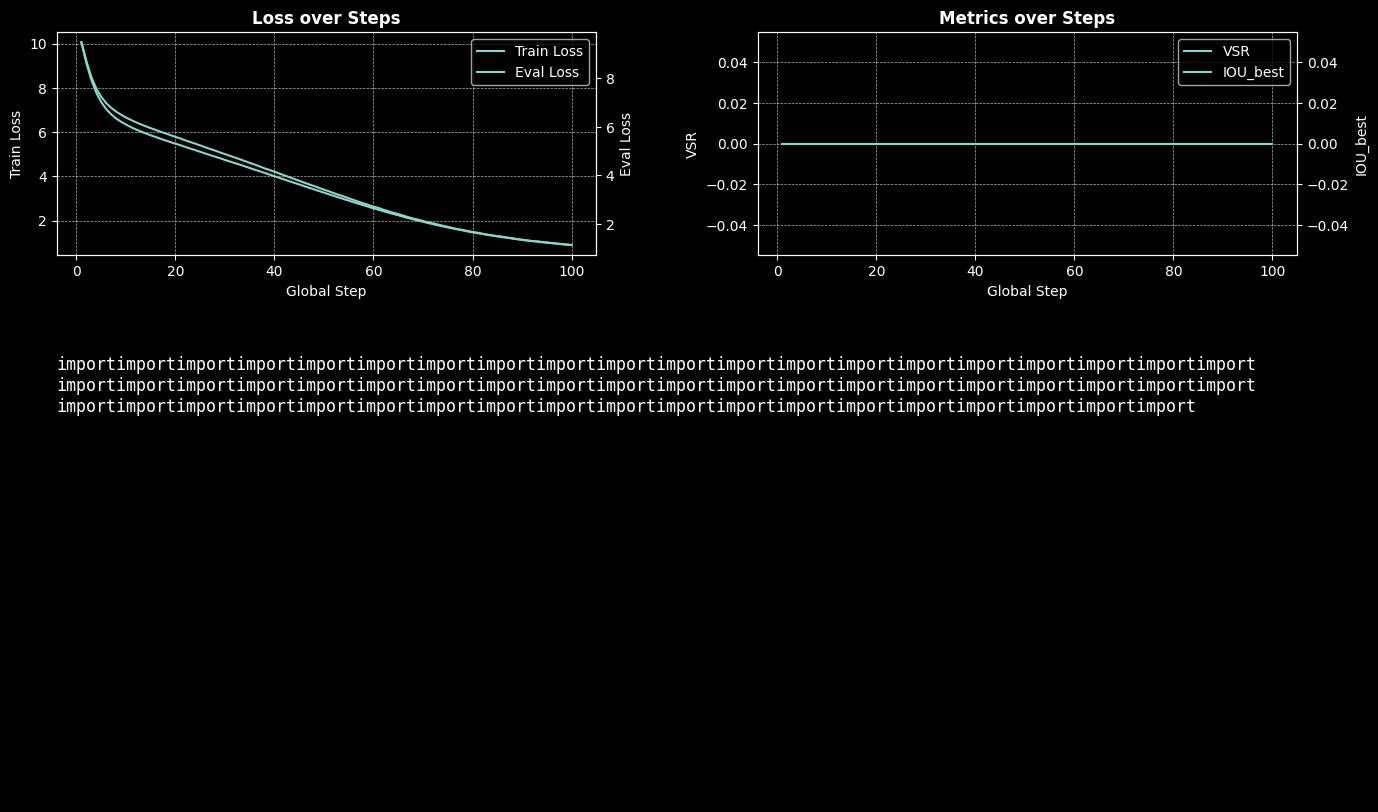

In [82]:
# 3) Run training + evaluation
steps, train_losses, eval_losses = [], [], []
train_accs, eval_accs, vsrs, ious = [], [], [], []
global_step = 0
num_epochs = 100

for epoch in range(1, num_epochs + 1):
    train_loss = train_one_epoch(model, train_loader, optimizer, device)
    val_loss, vsr, iou, code_text = evaluate(model, val_loader, device)

    global_step += 1
    
    # Append to histories
    steps.append(global_step)
    train_losses.append(train_loss)
    eval_losses.append(val_loss)
    vsrs.append(vsr)
    ious.append(iou)

    # Live‑update the plot
    update_plot(
        steps, train_losses, eval_losses,
        vsrs, ious, 
        code_text=code_text,
        optimizer=optimizer, 
        global_step=global_step,
        curr_epoch=epoch,
    )


# My FeedBack

I really loved the project. At first, I thought it would be difficult, but I quickly realized it wasn’t as crazy as I expected.

It was my first time working on this kind of idea using a model built completely from scratch.

I genuinely enjoyed the experience, even though the 7 hours weren't enough for me — there's a lot to test and tweak, and I only have a single GPU.

Still, it was a really cool project!

If I had more time:

1. I would have made the architecture work correctly from the beginning.
2. I would have improved the training process for code generation and augmented the dataset using techniques like rotation and flipping. (Of course, not all augmentations are suitable — some could change the shape or hide parts of it, which isn’t ideal for CAD data.)
3. I would have tried different transformer architectures and decoders. Instead of relying solely on ResNet, I could have experimented with a full ViT model.
4. I would have completed the project and built an application around it — and had fun showing it off with pride! 😄
